In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sklearn.linear_model
from scipy.optimize import curve_fit

In [2]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [3]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()

In [4]:
start_date = '2021-01-01'
end_date = '2021-03-09'

In [5]:
query = """
select
    ctp.android_package_name
    , datediff(day, ctp.tracking_time::timestamp, ign.eventdate::timestamp) as tti_days
    , count(distinct ign.IgniteID)*16 as ignite_first_opens
from rawdata.campaign_tracking_active_preload ctp
join 
(
    select 
        p.uid || '_' || t.transactionid AS IgniteID
        , te.eventdate at time zone 'utc' at time zone 'America/New_York' as eventdate
    from rawdata.dt_transactions t
    join rawdata.dt_transactions_events te 
        on te.TransactionId = t.TransactionId 
        AND te.rs_carrier_id = t.rs_carrier_id
    join rawdata.dt_events e 
        on e.eventId=te.eventId
        and e.rs_carrier_id = te.rs_carrier_id
    join rawdata.dt_process p 
        on t.processid = p.ProcessId 
        and p.rs_carrier_id = t.rs_carrier_id
        and left(p.uid,1) = '0'
    join rawdata.dt_carrier_apps ca 
        on ca.carrierappid = t.carrierappid 
        and ca.rs_carrier_id = p.rs_carrier_id
    join rawdata.dt_app a 
        on a.appid = ca.appid 
        and a.rs_carrier_id = ca.rs_carrier_id
    where e.code = 612
        and a.packagename like 'com.king.%'
        and date(te.eventdate) >= '{start_date}'
        and date(te.eventdate) <= '{end_date}'
    group by 1,2
) ign
    on ctp.reqid = ign.IgniteID
    and ign.eventdate >= ctp.tracking_time
where
    left(ctp.reqid,1) = '0'
    and ctp.android_package_name like 'com.king.%'
    and ctp.country_code = 'US'
    and date(ctp.tracking_time) >= date('{start_date}') - interval '30 day'
    and date(ctp.tracking_time) <= date('{end_date}') 
group by 1,2
"""

In [6]:
cur_atlas.execute(query.format(start_date = start_date, end_date = end_date))
df = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [7]:
by_days = df.groupby('tti_days').sum()
by_days

ignite_first_opens
tti_days                    
0                     487968
1                     361968
2                     197504
3                     154400
4                     104080
...                      ...
92                        96
93                       112
94                        48
95                        64
97                        32

[97 rows x 1 columns]

In [8]:
query_roas = """
select
    tti
    , android_package_name
    , sum(install)*10 as install 
    , sum(d7_events)*10 as d7_events
    , sum(d7_rev)*10 as d7_rev 
    , sum(d14_events)*10 as d14_events
    , sum(d14_rev)*10 as d14_rev 
    , sum(d30_events)*10 as d30_events
    , sum(d30_rev)*10 as d30_rev 
    , sum(spend)*10 as spend 
from
(
    select
        cti.tracking_time::date - ctp.tracking_time::date as tti
        , cti.android_package_name
        , count(distinct cti.referrer) as install
        , 0 as d7_events
        , 0 as d7_rev
        , 0 as d14_events
        , 0 as d14_rev
        , 0 as d30_events
        , 0 as d30_rev
        , sum(case when cti.billing_type = 'CPI' then cti.settled_price_per_download else 0 end) as spend 
    from rawdata.campaign_tracking_active_install cti 
    join rawdata.campaign_tracking_active_preload ctp
        on cti.referrer = ctp.referrer
        and ctp.android_package_name like 'com.king.%'
        and ctp.country_code = 'US'
        and right(ctp.referrer,1) = '0'
        and date(ctp.tracking_time) >= date('{start_date}') - interval '7 day'
        and date(ctp.tracking_time) <= date('{end_date}') 
    where 
        date(cti.tracking_time) >= date('{start_date}')
        and date(cti.tracking_time) <= date('{end_date}')
        and right(cti.referrer,1) = '0'
        and cti.country_code = 'US'
    group by 1,2

    union all 

    select
        cti.tti
        , cti.android_package_name
        , 0 as install
        , count(distinct case when datediff(day, cti.tracking_time::timestamp, pi.event_date::timestamp) <= 7 
            then pi.referrer else NULL end) as d7_events
        , sum(case when event_var ~ '^[-+]?([0-9]*\.[0-9]+|[0-9]+)$' and datediff(day, cti.tracking_time::timestamp, pi.event_date::timestamp) <= 7
            then event_var else 0::varchar END) as d7_rev
        , count(distinct case when datediff(day, cti.tracking_time::timestamp, pi.event_date::timestamp) <= 14 
            then pi.referrer else NULL end) as d14_events
        , sum(case when event_var ~ '^[-+]?([0-9]*\.[0-9]+|[0-9]+)$' and datediff(day, cti.tracking_time::timestamp, pi.event_date::timestamp) <= 14
            then event_var else 0::varchar END) as d14_rev
        , count(distinct pi.referrer) as d30_events
        , sum(case when event_var ~ '^[-+]?([0-9]*\.[0-9]+|[0-9]+)$' then event_var else 0::varchar END) as d30_rev
        , 0 as spend 
    from rawdata.pi_data pi 
    join 
    (
        select
            cti.tracking_time::date - ctp.tracking_time::date as tti
            , cti.tracking_time
            , cti.android_package_name
            , cti.referrer
        from rawdata.campaign_tracking_active_install cti 
        join rawdata.campaign c 
            on cti.campaign_id = c.campaign_id
            and c.bid_price_per_download > 0
        join rawdata.campaign_tracking_active_preload ctp
            on cti.referrer = ctp.referrer
            and ctp.android_package_name like 'com.king.%'
            and right(ctp.referrer,1) = '0'
            and ctp.country_code = 'US'
            and date(ctp.tracking_time) >= date('{start_date}') - interval '7 day'
            and date(ctp.tracking_time) <= date('{end_date}') 
        where 
            date(cti.tracking_time) >= date('{start_date}')
            and date(cti.tracking_time) <= date('{end_date}')
            and cti.country_code = 'US'
            and right(cti.referrer,1) = '0'
            and cti.android_package_Name like 'com.king.%'
        group by 1,2,3,4
    ) cti
        on cti.referrer = pi.referrer
        and datediff(day, cti.tracking_time::timestamp, pi.event_date::timestamp) <= 30
        and pi.event_date >= cti.tracking_time      
    where 
        date(event_date) >= date('{start_date}')
        and date(event_date) <= date('{end_date}') + interval '30 day' 
        and pi.app_id like 'com.king.%'
        and right(pi.referrer,1) = '0'
        and pi.event = 'af_purchase'
    group by 1,2
) t
group by 1,2
"""

In [9]:
cur_atlas.execute(query_roas.format(start_date = start_date, end_date = end_date))
df_roas = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

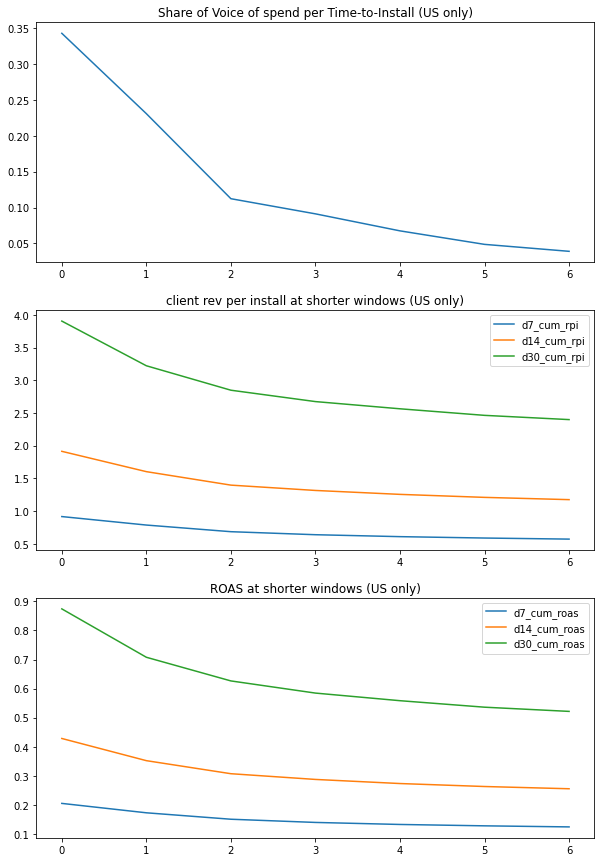

In [14]:
df_roas['spend'] = df_roas['spend'].astype('float')
df_roas['spend_sov'] = df_roas['spend']/df_roas['spend'].sum()
df_roas['d7_rev'] = df_roas['d7_rev'].astype('float')
df_roas['d14_rev'] = df_roas['d14_rev'].astype('float')
df_roas['d30_rev'] = df_roas['d30_rev'].astype('float')
by_tti = df_roas[(df_roas.tti >= 0) & (df_roas.tti <= 6)].groupby('tti').sum()
by_tti['cpi'] = by_tti['spend']/by_tti['install']
by_tti['cum_spend'] = by_tti['spend'].cumsum()
by_tti['d7_cum_rpi'] = by_tti['d7_rev'].cumsum()/by_tti['install'].cumsum()
by_tti['d14_cum_rpi'] = by_tti['d14_rev'].cumsum()/by_tti['install'].cumsum()
by_tti['d30_cum_rpi'] = by_tti['d30_rev'].cumsum()/by_tti['install'].cumsum()
by_tti['d7_cum_roas'] = by_tti['d7_rev'].cumsum()/by_tti['spend'].cumsum()
by_tti['d14_cum_roas'] = by_tti['d14_rev'].cumsum()/by_tti['spend'].cumsum()
by_tti['d30_cum_roas'] = by_tti['d30_rev'].cumsum()/by_tti['spend'].cumsum()
by_tti['d7_cum_purchase_rate'] = by_tti['d7_events'].cumsum()/by_tti['install'].cumsum()
by_tti['d14_cum_purchase_rate'] = by_tti['d14_events'].cumsum()/by_tti['install'].cumsum()
by_tti['d30_cum_purchase_rate'] = by_tti['d30_events'].cumsum()/by_tti['install'].cumsum()

fig, ax = plt.subplots(3,1,figsize = (10,15))
ax[0].plot(by_tti[['spend_sov']])
ax[0].set_title('Share of Voice of spend per Time-to-Install (US only)')
ax[1].plot(by_tti[['d7_cum_rpi','d14_cum_rpi','d30_cum_rpi']])
ax[1].set_title('client rev per install at shorter windows (US only)')
ax[1].legend(['d7_cum_rpi','d14_cum_rpi','d30_cum_rpi'])
ax[2].plot(by_tti[['d7_cum_roas','d14_cum_roas','d30_cum_roas']])
x[2].set_title('ROAS at shorter windows (US only)')
ax[2].legend(['d7_cum_roas','d14_cum_roas','d30_cum_roas'])

In [15]:
by_tti

install  d7_events    d7_rev  d14_events   d14_rev  d30_events  \
tti                                                                   
0     320980       5680  293850.0        7420  614010.0        9400   
1     206010       3290  120260.0        4260  230320.0        5360   
2     103900        950   17560.0        1300   36500.0        1720   
3      79500        710   21610.0         990   53120.0        1220   
4      58780        390   14740.0         590   31190.0         910   
5      43540        330    9290.0         490   17360.0         660   
6      34880        270    6530.0         360   12790.0         510   

       d30_rev      spend  spend_sov       cpi  cum_spend  d7_cum_rpi  \
tti                                                                     
0    1253110.0  1433228.4   0.342795  4.465164  1433228.4    0.915478   
1     444320.0   964899.2   0.230781  4.683749  2398127.6    0.785802   
2      98870.0   469395.0   0.112268  4.517757  2867522.6    0.684224   
3     102800.0   381138.6   0.091160  4.794196  3248661.2    0.638072   
4      72410.0   282000.3   0.067448  4.797555  3530661.5    0.608474   
5      30080.0   203302.9   0.048625  4.669336  3733964.4    0.587307   
6      30940.0   162781.9   0.038934  4.666912  3896746.3    0.570842   

     d14_cum_rpi  d30_cum_rpi  d7_cum_roas  d14_cum_roas  d30_cum_roas  \
tti                                                                      
0       1.912923     3.904013     0.205027      0.428410      0.874327   
1       1.602175     3.220991     0.172681      0.352079      0.707815   
2       1.396170     2.847248     0.150538      0.307175      0.626429   
3       1.314700     2.673320     0.139528      0.287488      0.584579   
4       1.254781     2.563165     0.132559      0.273360      0.558397   
5       1.208918     2.462859     0.127829      0.263125      0.536050   
6       1.174259     2.398011     0.124165      0.255416      0.521597   

     d7_cum_purchase_rate  d14_cum_purchase_rate  d30_cum_purchase_rate  
tti                                                                      
0                0.017696               0.023117               0.029285  
1                0.017021               0.022164               0.028008  
2                0.015724               0.020574               0.026122  
3                0.014964               0.019665               0.024916  
4                0.014327               0.018929               0.024195  
5                0.013966               0.018518               0.023711  
6                0.013709               0.018181               0.023337

Text(0.5, 0, 'Time-to-Install (d)')

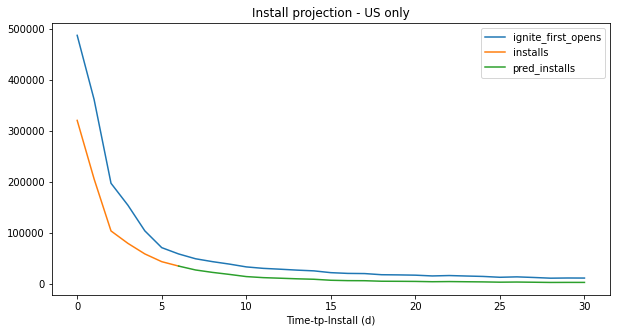

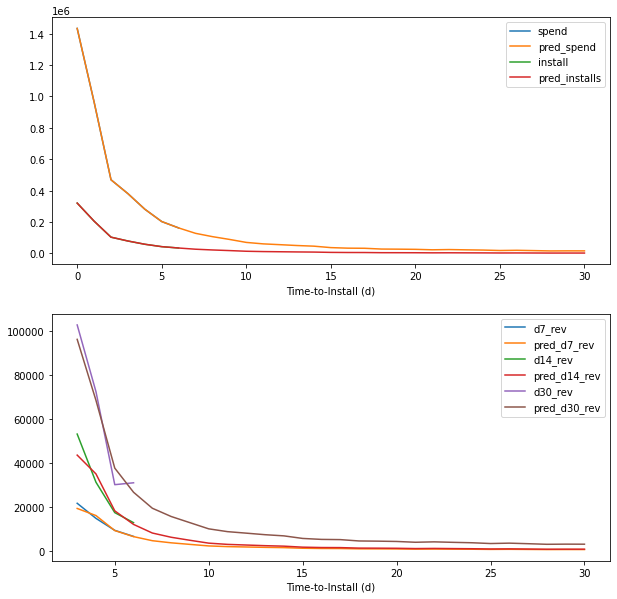

In [71]:
joined = by_days.join(by_tti, how = 'left')
joined['ignite_first_opens'] = joined['ignite_first_opens'].astype(float)

coefs_install = np.polyfit(joined.loc[0:6, 'ignite_first_opens'], np.log(joined.loc[0:6, 'install']), 6)
coefs_spend = np.polyfit(joined.loc[0:6, 'ignite_first_opens'], np.log(joined.loc[0:6, 'spend']), 6)
coefs_d7_rev = np.polyfit(joined.loc[0:6, 'ignite_first_opens'], np.log(joined.loc[0:6, 'd7_rev']), 4)
coefs_d14_rev = np.polyfit(joined.loc[0:6, 'ignite_first_opens'], np.log(joined.loc[0:6, 'd14_rev']), 4)
coefs_d30_rev = np.polyfit(joined.loc[0:6, 'ignite_first_opens'], np.log(joined.loc[0:6, 'd30_rev']), 4)

joined['pred_installs'] = np.exp(np.polyval(coefs_install, joined.ignite_first_opens))
joined['pred_spend'] = np.exp(np.polyval(coefs_spend, joined.ignite_first_opens))
joined['pred_d7_rev'] = np.exp(np.polyval(coefs_d7_rev, joined.ignite_first_opens))
joined['pred_d14_rev'] = np.exp(np.polyval(coefs_d14_rev, joined.ignite_first_opens))
joined['pred_d30_rev'] = np.exp(np.polyval(coefs_d30_rev, joined.ignite_first_opens))

install_formulation = joined.loc[0:30, ['ignite_first_opens', 'install', 'pred_installs']]
install_formulation.loc[7:30, 'install'] = np.nan
install_formulation.loc[:5, 'pred_installs'] = np.nan

plt.figure(figsize = (10,5))
plt.plot(install_formulation)
plt.legend(['ignite_first_opens','installs','pred_installs'])
plt.xlabel('Time-tp-Install (d)')
plt.title('Install projection - US only')

fig, ax = plt.subplots(2,1, figsize = (10,10))
ax[0].plot(joined.loc[0:30, ['spend','pred_spend','install','pred_installs']])
ax[0].legend(['spend','pred_spend','install','pred_installs'])
ax[0].set_xlabel('Time-to-Install (d)')
ax[1].plot(joined.loc[3:30, ['d7_rev','pred_d7_rev','d14_rev','pred_d14_rev','d30_rev','pred_d30_rev']])
ax[1].legend(['d7_rev','pred_d7_rev','d14_rev','pred_d14_rev','d30_rev','pred_d30_rev'])
ax[1].set_xlabel('Time-to-Install (d)')

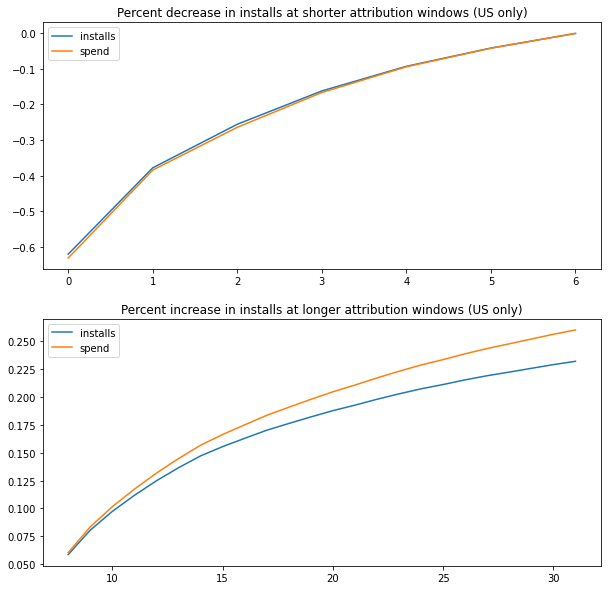

In [68]:
joined['proj_diff_installs'] = joined['pred_installs'].cumsum()/joined.loc[:6,'pred_installs'].sum()-1
joined['proj_diff_spend'] = joined['pred_spend'].cumsum()/joined.loc[:6,'pred_spend'].sum()-1
fig, ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(joined.loc[0:6, ['proj_diff_installs','proj_diff_spend']])
ax[0].set_title('Percent decrease in installs at shorter attribution windows (US only)')
ax[0].legend(['installs','spend'])
ax[1].plot(joined.loc[8:31, ['proj_diff_installs','proj_diff_spend']])
ax[1].set_title('Percent increase in installs at longer attribution windows (US only)')
ax[1].legend(['installs','spend'])

In [70]:
print('install',coefs_install)
print('spend',coefs_spend)
print('d7_rev',coefs_d7_rev)
print('d14_rev',coefs_d14_rev)
print('d30_rev',coefs_d30_rev)
joined.loc[:30, 'ignite_first_opens'].to_list()

install [-5.61743404e-32  8.07466708e-26 -4.49286427e-20  1.23751331e-14
 -1.79147396e-09  1.36271865e-04  6.60971778e+00]
spend [-4.97303520e-32  7.01388412e-26 -3.82986675e-20  1.04168918e-14
 -1.51306531e-09  1.18592918e-04  8.55315255e+00]
d7_rev [-1.62352296e-21  1.73461399e-15 -6.09314813e-10  8.76903308e-05
  5.38993750e+00]
d14_rev [-1.74048306e-21  1.89161173e-15 -6.80371997e-10  9.98276271e-05
  5.51420650e+00]
d30_rev [-1.13994309e-21  1.26511150e-15 -4.68867580e-10  7.39858221e-05
  7.21986110e+00]


[487968.0,
 361968.0,
 197504.0,
 154400.0,
 104080.0,
 71088.0,
 58704.0,
 49248.0,
 43600.0,
 38800.0,
 33280.0,
 30416.0,
 28752.0,
 26944.0,
 25488.0,
 21968.0,
 20512.0,
 20176.0,
 17920.0,
 17584.0,
 17040.0,
 15520.0,
 16304.0,
 15376.0,
 14560.0,
 12896.0,
 13712.0,
 12512.0,
 11120.0,
 11488.0,
 11360.0]

In [ ]:
query_notification = """
select
    c.tracking_time::date - p.tracking_time::date as time_to_notification
    , count(distinct c.advertising_id) as notifications
    , count(distinct c.advertising_id)/sum(count(distinct c.advertising_id)) over ()::double precision as sov 
from
(
    select
        advertising_id
        , tracking_time
    from rawdata.campaign_tracking_active_preload ctp
    where
        date(ctp.tracking_time) >= '{start_date}'
        and date(ctp.tracking_time) <= '{end_date}'
        and right(ctp.referrer,1) = '0'
        and android_package_name like 'com.king.%'
    group by 1,2
) p
left join
(
    select
        advertising_id
        , tracking_time
    from rawdata.campaign_tracking_active_click ctc
    where
        date(ctc.tracking_time) >= '{start_date}'
        and date(ctc.tracking_time) <= date('{end_date}') + 30
        and right(ctc.referrer,1) = '0'
        and sti_type = 'Not Single Tap'
        and android_package_name like 'com.king.%'
    group by 1,2
) c
    on p.advertising_id = c.advertising_Id
    and c.tracking_time >= p.tracking_time
group by 1
order by 1
"""

In [17]:
cur_atlas.execute(query_notification.format(start_date = start_date, end_date = end_date))
df_notification = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])